In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import mnist, fashion_mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import warnings
warnings.filterwarnings("ignore")
import wandb
import seaborn as sns

In [47]:
batchsize = 16
no_of_features = 784
no_of_classes = 10
no_of_layers = 5
no_of_neurons_in_each_layer = [128,128,128]

In [48]:
from keras.datasets import fashion_mnist


In [49]:
(X,Y),(X_test,Y_test) = fashion_mnist.load_data()

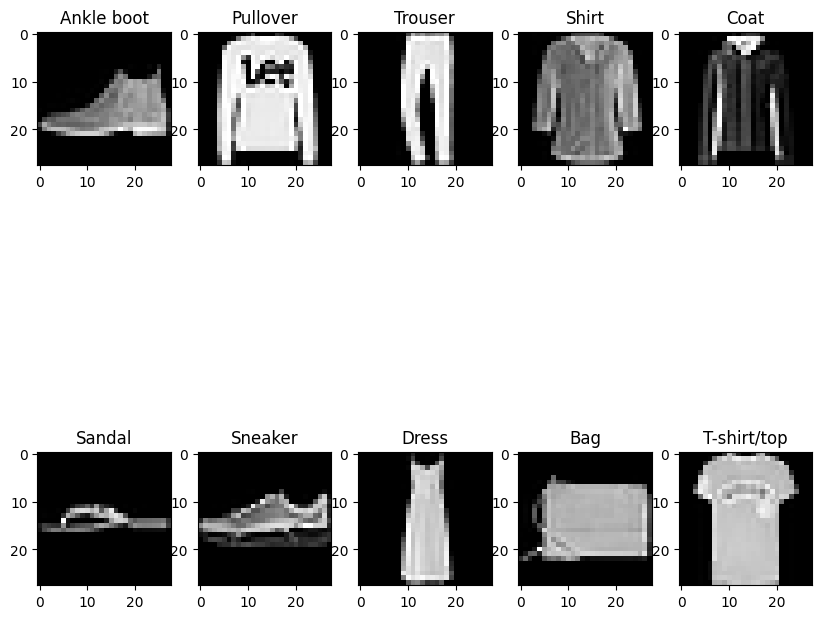

In [50]:
visited_label = []
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
fig,axes = plt.subplots(2,5,figsize=(10,10))
axes = axes.flatten()
index = 0
for x in range(len(X_test)):
    if(Y_test[x] not in visited_label):
        visited_label.append(Y_test[x])
        axes[index].imshow(X_test[x],cmap = plt.cm.gray)
        axes[index].set_title("{}".format(class_names[Y_test[x]]))
        index += 1
plt.show()
        



In [51]:
X = X.reshape(len(X),784,1)
X[0].shape
X_test = X_test.reshape(len(X_test),784,1)
X_test[0].shape



(784, 1)

In [52]:
X = X/255.0
X_test = X_test/255.0

In [55]:
X_train,X_val,Y_train,Y_val = train_test_split(X,Y,test_size=0.1,random_state=42)

In [56]:
X_train.shape

(54000, 784, 1)

In [58]:
def compute_loss(Y_hat,Y):
    temp = []
    for x in range(len(Y)):
        temp.append(one_hot(Y[x],no_of_classes))
    temp = np.array(temp)
    return (-1.0 * np.sum(np.multiply(temp,np.log(Y_hat+1e-9).reshape(Y_hat.shape[0],Y_hat.shape[1]))))



In [ ]:
#grad wrt output layer preactivation
# correct
def compute_grad_preactivation_output(activation,Y):
    grads = []
    for x in range(len(activation[-1])):
        act = activation[-1][x]
        grad = np.array([0]*len(act)).reshape(len(act),1)
        index = Y[x]
        grad[index] = 1
        grads.append(-(grad - act))
    return np.array(grads)
    




In [ ]:
def compute_grad_weight(grad_ak,hk_1):
    temp = []
    for x in range(len(grad_ak)):
        temp.append(np.matmul(grad_ak[x],hk_1[x].T))
    return np.array(temp)

In [ ]:
def compute_grad_activation(wk,grad_ak):
    return np.matmul(wk.T,grad_ak)

In [ ]:
def compute_grad_preactivation(grad_hk_1,ak_1):
    return np.multiply(grad_hk_1,sigmoid_derivative(ak_1))

In [ ]:
def back_propagate(activation,preactivation,thetas,Y):
    grads = {}
    grads['a' + str(no_of_layers-1)] = compute_grad_preactivation_output(activation,Y)
    for k in range(no_of_layers-1,0,-1):
        grads['W'+str(k)] = np.sum(compute_grad_weight(grads['a' + str(k)],activation[k-1]),axis = 0)/batchsize
        grads['b'+str(k)] = np.sum(grads['a' + str(k)],axis = 0)/batchsize
        if(k == 1):
            break
        grads['h'+str(k-1)] = compute_grad_activation(thetas['W'+str(k)],grads['a'+str(k)])
        grads['a'+str(k-1)] = compute_grad_preactivation(grads['h'+str(k-1)],preactivation[k-1])
    return grads

In [ ]:
def back_propagate(h,a,thetas,Y):
    grads = {}
    for x in thetas.keys():
        grads[x] = 0
    for x in range(len(Y)):
        temp = h[-1][x] - one_hot(Y[x],no_of_classes).reshape(no_of_classes,1)
        for k in range(no_of_layers-1,0,-1):
            W = 'W' + str(k)
            b = 'b' + str(k)
            grads[W] += np.matmul(temp,h[k-1][x].T)
            grads[b] += temp
            if(k == 1):
                break
            temp = np.matmul(thetas[W].T,temp)
            temp = np.multiply(temp,Relu_derivative(a[k-1][x]))
    return grads

In [ ]:
def gradient_descent(optimizer):
    thetas = uniform_initialization(no_of_features,no_of_classes,no_of_layers,no_of_neurons_in_each_layer)
    max_epochs = 15
    eta = 0.01
    beta1 = 0.9
    beta2 = 0.99
    delta = 1e-5
    grads = {}
    for i in thetas.keys():
        grads[i] = 0
    for t in range(max_epochs):
        #previous_update
        ut = {}
        vt = {}
        for i in thetas.keys():
            ut[i] = 0
            vt[i] = 0
        params_look_ahead = {}
        for x in range(0,X_train.shape[0],batchsize):
            if(optimizer == 'nesterov'):
                for i in thetas.keys():
                    params_look_ahead[i] = thetas[i] - beta*ut[i]
                activation,preactivation = feed_forward(X_train[x:x+batchsize],thetas,no_of_layers)
                grads = back_propagate(activation,preactivation,params_look_ahead,Y_train[x:x+batchsize])
                for i in thetas.keys():
                    ut[i] = beta1*ut[i] + (1-beta1)*grads[i]
                    thetas[i] = thetas[i] - eta*ut[i]
            elif(optimizer == 'mgd'):
                activation,preactivation = feed_forward(X_train[x:x+batchsize],thetas,no_of_layers)
                grads = back_propagate(activation,preactivation,thetas,Y_train[x:x+batchsize])     
                for i in thetas.keys():
                    ut[i] = beta1*ut[i] + grads[i]
                    thetas[i] = thetas[i] - eta*ut[i]
            elif(optimizer == 'sgd'):
                activation,preactivation = feed_forward(X_train[x:x+batchsize],thetas,no_of_layers)
                grads = back_propagate(activation,preactivation,thetas,Y_train[x:x+batchsize])
                for i in thetas.keys():
                    thetas[i] = thetas[i] - eta*grads[i]
            elif(optimizer == 'RMSprop'):
                activation,preactivation = feed_forward(X_train[x:x+batchsize],thetas,no_of_layers)
                grads = back_propagate(activation,preactivation,thetas,Y_train[x:x+batchsize])
                for i in thetas.keys():
                    ut[i] = beta1*ut[i] + (1-beta1)*np.multiply(grads[i],grads[i])
                    thetas[i] = thetas[i] - eta*grads[i]/((np.sqrt(ut[i])+delta))
            elif(optimizer == 'adam'):
                activation,preactivation = feed_forward(X_train[x:x+batchsize],thetas,no_of_layers)
                grads = back_propagate(activation,preactivation,thetas,Y_train[x:x+batchsize])
                for i in thetas.keys():
                    ut[i] = beta1*ut[i] + (1-beta1)*grads[i]
                    uthat = ut[i]/(1 - pow(beta1,t+1))
                    vt[i] = beta2*vt[i] + (1-beta2)*np.multiply(grads[i],grads[i])
                    vthat = vt[i]/(1 - pow(beta2,t+1))
                    thetas[i] = thetas[i] - eta*uthat/((np.sqrt(vthat) + delta))
            elif(optimizer == 'nadam'):
                activation,preactivation = feed_forward(X_train[x:x+batchsize],thetas,no_of_layers)
                grads = back_propagate(activation,preactivation,thetas,Y_train[x:x+batchsize])
                for i in thetas.keys():
                    ut[i] = beta1*ut[i] + (1-beta1)*grads[i]
                    uthat = ut[i]/(1 - pow(beta1,t+1))
                    vt[i] = beta2*vt[i] + (1-beta2)*np.multiply(grads[i],grads[i])
                    vthat = vt[i]/(1 - pow(beta2,t+1))
                    thetas[i] = thetas[i] - (eta*(beta1*uthat + (1-beta1)*grads[i]/(1-pow(beta1,t+1))))/(np.sqrt(vthat) + delta)
        ac,pre = feed_forward(X_train[:],thetas,no_of_layers)
        print_accuracy(ac,Y_train)   
            
    return thetas
    

In [ ]:
def print_accuracy(yhat,y):
    correct = 0
    for x in range(len(yhat[-1])):
        if(np.argmax(yhat[-1][x]) == y[x]):
            correct+=1
    print(correct/len(y)*100)

In [ ]:
t = gradient_descent(optimizer='mgd')

In [190]:
class NeuralNetwork:
    def __init__(self,optimizer,batchsize,no_of_features,no_of_classes,no_of_layers,no_of_neurons_in_each_layer,max_epochs,eta,initialization_method,activation_method,loss):
        self.optimizer  = optimizer
        self.batchsize = batchsize
        self.no_of_features = no_of_features
        self.no_of_classes = no_of_classes
        self.no_of_layers = no_of_layers
        self.no_of_neurons_in_each_layer = no_of_neurons_in_each_layer
        self.max_epochs = max_epochs
        self.eta = eta
        self.initialization = initialization_method
        self.initialization_list = {'xavier':self.xavier_initialization,'uniform':self.uniform_initialization,'normal':self.normal_initialization,'he':self.he_initialization}
        self.activation = activation_method
        self.activation_list = {'sigmoid':self.sigmoid,'relu':self.Relu,'tanh':self.tanh}
        self.activation_derivative = {'sigmoid':self.sigmoid_derivative,'relu':self.Relu_derivative,'tanh':self.tanh_derivative}
        self.loss = loss
        self.thetas = {}
    def one_hot(self,l,no_of_classes):
        temp = np.array([0]*no_of_classes)
        temp[l] = 1
        return temp
    def sigmoid(self,x):
        return 1. / (1.+np.exp(-x))

    def sigmoid_derivative(self,x):
        return self.sigmoid(x) * (np.ones_like(x)-self.sigmoid(x))

    def Relu(self,x):
        return np.maximum(0,x)

    def Relu_derivative(self,x):
        return 1*(x>0) 

    def tanh(self,x):
        return np.tanh(x)

    def tanh_derivative(self,x):
        return (1 - (np.tanh(x)**2))

    def softmax(self,x):
        l = []
        for i in range(len(x)):
            l.append(np.exp(x[i])/np.sum(np.exp(x[i]),axis=0))
        return np.array(l)
        
    def softmax_derivative(self,x):
        for i in range(len(x)):
            x[i] = x[i] / max(x[i])
        return self.softmax(x) * (1-self.softmax(x))

    def he_initialization(self):
        np.random.seed(42)
        thetas = {}
        for layer in range(1,self.no_of_layers):
            if(layer == 1):
                thetas['W'+str(layer)] = np.random.normal(0,1,size = (self.no_of_neurons_in_each_layer[layer-1],self.no_of_features)) * np.sqrt(2/(self.no_of_neurons_in_each_layer[layer-1]))
                thetas['b'+str(layer)] = np.random.normal(0,1,size = (self.no_of_neurons_in_each_layer[layer-1],1))*np.sqrt(2/self.no_of_neurons_in_each_layer[layer-1])
            elif(layer == self.no_of_layers-1):
                thetas['W'+str(layer)] = np.random.normal(0,1,size = (self.no_of_classes,self.no_of_neurons_in_each_layer[layer-2])) * np.sqrt(2/(self.no_of_classes))
                thetas['b'+str(layer)] = np.random.normal(0,1,size = (self.no_of_classes,1)) * np.sqrt(2/(self.no_of_classes))
            else:
                thetas['W'+str(layer)] = np.random.normal(0,1,size = (self.no_of_neurons_in_each_layer[layer-1],self.no_of_neurons_in_each_layer[layer-2])) * np.sqrt(2/(self.no_of_neurons_in_each_layer[layer-1]))
                thetas['b'+str(layer)] = np.random.normal(0,1,size = (self.no_of_neurons_in_each_layer[layer-1],1)) * np.sqrt(2/self.no_of_neurons_in_each_layer[layer-1])
        return thetas

    def xavier_initialization(self):
        np.random.seed(42)
        thetas = {}
        for layer in range(1,self.no_of_layers):
            if(layer == 1):
                thetas['W'+str(layer)] = np.random.randn(self.no_of_neurons_in_each_layer[layer-1],self.no_of_features) * np.sqrt(2/(self.no_of_neurons_in_each_layer[layer-1]+self.no_of_features))
                thetas['b'+str(layer)] = np.zeros((self.no_of_neurons_in_each_layer[layer-1],1))
            elif(layer == self.no_of_layers-1):
                thetas['W'+str(layer)] = np.random.randn(self.no_of_classes,no_of_neurons_in_each_layer[layer-2]) * np.sqrt(2/(self.no_of_classes + self.no_of_neurons_in_each_layer[layer-2]))
                thetas['b'+str(layer)] = np.zeros((self.no_of_classes,1))
            else:
                # print(layer)
                # print(self.no_of_neurons_in_each_layer[layer-1])
                # print(self.no_of_neurons_in_each_layer[layer-2])
                thetas['W'+str(layer)] = np.random.randn(self.no_of_neurons_in_each_layer[layer-1],self.no_of_neurons_in_each_layer[layer-2]) * np.sqrt(2/(self.no_of_neurons_in_each_layer[layer-1]+self.no_of_neurons_in_each_layer[layer-2]))
                thetas['b'+str(layer)] = np.zeros((self.no_of_neurons_in_each_layer[layer-1],1))
        return thetas

    def uniform_initialization(self):
        thetas = {}
        np.random.seed(42)
        for layer in range(1,self.no_of_layers):
            if(layer == 1):
                thetas['W'+str(layer)] = np.random.default_rng().uniform(low = -0.7,high =0.7,size = (self.no_of_neurons_in_each_layer[layer-1],self.no_of_features)) #* np.sqrt(2/(no_of_neurons_in_each_layer[layer-1]+no_of_features))
                thetas['b'+str(layer)] = np.random.default_rng().uniform(low = -0.7,high =0.7,size = (self.no_of_neurons_in_each_layer[layer-1],1))
            elif(layer == self.no_of_layers-1):
                thetas['W'+str(layer)] = np.random.default_rng().uniform(low = -0.7,high =0.7,size = (self.no_of_classes,self.no_of_neurons_in_each_layer[layer-2])) #* np.sqrt(2/(no_of_classes + no_of_neurons_in_each_layer[layer-2]))
                thetas['b'+str(layer)] = np.random.default_rng().uniform(low = -0.7,high =0.7,size = (self.no_of_classes,1))
            else:
                thetas['W'+str(layer)] = np.random.default_rng().uniform(low = -0.7,high =0.7,size =(self.no_of_neurons_in_each_layer[layer-1],self.no_of_neurons_in_each_layer[layer-2])) #*  np.sqrt(2/(no_of_neurons_in_each_layer[layer-1]+no_of_neurons_in_each_layer[layer-2]))
                thetas['b'+str(layer)] = np.random.default_rng().uniform(low = -0.7,high =0.7,size = (self.no_of_neurons_in_each_layer[layer-1],1))
        return thetas

    def normal_initialization(self):
        thetas = {}
        np.random.seed(42)
        for layer in range(1,self.no_of_layers):
            if(layer == 1):
                thetas['W'+str(layer)] = np.random.uniform(low = -0.7,high =0.7,size = (self.no_of_neurons_in_each_layer[layer-1],self.no_of_features)) #* np.sqrt(2/(no_of_neurons_in_each_layer[layer-1]+no_of_features))
                thetas['b'+str(layer)] = np.zeros((self.no_of_neurons_in_each_layer[layer-1],1))
            elif(layer == self.no_of_layers-1):
                thetas['W'+str(layer)] = np.random.uniform(low = -0.7,high =0.7,size = (self.no_of_classes,self.no_of_neurons_in_each_layer[layer-2])) #* np.sqrt(2/(no_of_classes + no_of_neurons_in_each_layer[layer-2]))
                thetas['b'+str(layer)] = np.zeros((self.no_of_classes,1))
            else:
                thetas['W'+str(layer)] = np.random.uniform(low = -0.7,high =0.7,size =(self.no_of_neurons_in_each_layer[layer-1],self.no_of_neurons_in_each_layer[layer-2])) #*  np.sqrt(2/(no_of_neurons_in_each_layer[layer-1]+no_of_neurons_in_each_layer[layer-2]))
                thetas['b'+str(layer)] = np.zeros((self.no_of_neurons_in_each_layer[layer-1],1))
        return thetas

    def feed_forward(self,data,thetas,layers):
        pre_activation = [1]*(layers)
        activation  = [1]*(layers)
        activation[0] = data
        for layer_no in range(1,layers):
            W = 'W' + str(layer_no)
            b = 'b' + str(layer_no)
            pre_activation[layer_no] = np.add(np.matmul(thetas[W],activation[layer_no - 1]),thetas[b])
            if(layer_no == layers-1):
                activation[layer_no] = self.softmax(pre_activation[layer_no])
            else:
                activation[layer_no] = self.activation_list[self.activation](pre_activation[layer_no])
        return activation,pre_activation

    def back_propagate(self,h,a,thetas,Y):
        grads = {}
        for x in thetas.keys():
            grads[x] = 0
        for x in range(len(Y)):
            temp = h[-1][x] - self.one_hot(Y[x],self.no_of_classes).reshape(self.no_of_classes,1)
            for k in range(self.no_of_layers-1,0,-1):
                W = 'W' + str(k)
                b = 'b' + str(k)
                grads[W] += np.matmul(temp,h[k-1][x].T)/self.batchsize
                grads[b] += temp/self.batchsize
                if(k == 1):
                    break
                temp = np.matmul(thetas[W].T,temp)
                temp = np.multiply(temp,self.activation_derivative[self.activation](a[k-1][x]))
        return grads

    def momentumUpdate(self,t,maxm=.999):
        x=np.log(np.floor(t/250)+1)/np.log(2)
        x=1-2**(-1-x)
        return min(x,maxm)

    def getGamma(self,epoch):
        x=np.log((epoch/250)+1)
        x=-1-1*(x)
        x=2**x
        x=1-x
        return min(x,.9)

    def fit(self,X_train,Y_train):
        self.thetas = self.initialization_list[self.initialization]()
        delta = 1e-5
        grads = {}
        for i in self.thetas.keys():
            grads[i] = 0
        for t in range(self.max_epochs):
            #previous_update
            ut = {}
            vt = {}
            gamma = self.getGamma(t+1)
            beta = self.momentumUpdate(t+1)
            for i in self.thetas.keys():
                ut[i] = 0
                vt[i] = 0
            params_look_ahead = {}
            step = 1
            for x in range(0,X_train.shape[0],self.batchsize):
                beta1 = self.momentumUpdate(step)
                beta2 = self.momentumUpdate(step)
                if(self.optimizer == 'nesterov'):
                    for i in self.thetas.keys():
                        params_look_ahead[i] = self.thetas[i] - beta1*ut[i]
                    activation,preactivation = self.feed_forward(X_train[x:x+self.batchsize],self.thetas,self.no_of_layers)
                    grads = self.back_propagate(activation,preactivation,params_look_ahead,Y_train[x:x+self.batchsize])
                    for i in self.thetas.keys():
                        ut[i] = beta1*ut[i] + (1-beta1)*grads[i]
                        self.thetas[i] = self.thetas[i] - self.eta*ut[i]
                elif(self.optimizer == 'mgd'):
                    activation,preactivation = self.feed_forward(X_train[x:x+self.batchsize],self.thetas,self.no_of_layers)
                    grads = self.back_propagate(activation,preactivation,self.thetas,Y_train[x:x+self.batchsize])     
                    for i in self.thetas.keys():
                        ut[i] = gamma*ut[i] + grads[i]
                        self.thetas[i] = self.thetas[i] - self.eta*ut[i]
                elif(self.optimizer == 'sgd'):
                    activation,preactivation = self.feed_forward(X_train[x:x+self.batchsize],self.thetas,self.no_of_layers)
                    grads = self.back_propagate(activation,preactivation,self.thetas,Y_train[x:x+self.batchsize])
                    for i in self.thetas.keys():
                        self.thetas[i] = self.thetas[i] - self.eta*grads[i]
                elif(self.optimizer == 'RMSprop'):
                    activation,preactivation = self.feed_forward(X_train[x:x+self.batchsize],self.thetas,self.no_of_layers)
                    grads = self.back_propagate(activation,preactivation,self.thetas,Y_train[x:x+self.batchsize])
                    for i in self.thetas.keys():
                        ut[i] = beta*ut[i] + (1-beta)*np.multiply(grads[i],grads[i])
                        self.thetas[i] = self.thetas[i] - self.eta*grads[i]/((np.sqrt(ut[i])+delta))
                elif(self.optimizer == 'adam'):
                    activation,preactivation = self.feed_forward(X_train[x:x+self.batchsize],self.thetas,self.no_of_layers)
                    grads = self.back_propagate(activation,preactivation,self.thetas,Y_train[x:x+self.batchsize])
                    for i in self.thetas.keys():
                        ut[i] = beta1*ut[i] + (1-beta1)*grads[i]
                        uthat = ut[i]/(1 - pow(beta1,t+1))
                        vt[i] = beta2*vt[i] + (1-beta2)*np.multiply(grads[i],grads[i])
                        vthat = vt[i]/(1 - pow(beta2,t+1))
                        self.thetas[i] = self.thetas[i] - self.eta*uthat/((np.sqrt(vthat) + delta))
                elif(self.optimizer == 'nadam'):
                    activation,preactivation = self.feed_forward(X_train[x:x+self.batchsize],self.thetas,self.no_of_layers)
                    grads = self.back_propagate(activation,preactivation,self.thetas,Y_train[x:x+self.batchsize])
                    for i in self.thetas.keys():
                        ut[i] = beta1*ut[i] + (1-beta1)*grads[i]
                        uthat = ut[i]/(1 - pow(beta1,t+1))
                        vt[i] = beta2*vt[i] + (1-beta2)*np.multiply(grads[i],grads[i])
                        vthat = vt[i]/(1 - pow(beta2,t+1))
                        self.thetas[i] = self.thetas[i] - (self.eta*(beta1*uthat + (1-beta1)*grads[i]/(1-pow(beta1,t+1))))/(np.sqrt(vthat) + delta)  
                step+=1
            act,pre = self.feed_forward(X_train[:],self.thetas,self.no_of_layers)
            print(self.calculateLoss(act[-1],Y_train))
                
    def predict(self,X):
            activation,preactivation = self.feed_forward(X,self.thetas,self.no_of_layers)
            return activation[-1]

    def accuracy_score(self,X,Y):
        yhat = self.predict(X)
        correct = 0
        for x in range(len(yhat)):
            if(np.argmax(yhat[x]) == Y[x]):
                correct+=1
        print(correct/len(Y)*100)
    def calculateLoss(self,yHat,yBatch):
        loss=0
        if(self.loss == 'cross'):
            error = (-1)*np.log(yHat)*yBatch
            error=np.sum(error,axis=1)
            loss=np.mean(error)   
        if(self.loss == 'mse'):
                error = (yHat-yBatch)
                error=error**2
                loss = np.sum(error,axis=0) 
                loss = np.sum(error)  
                loss = loss/2
        return loss

        
        
        

    
    

In [2]:
NN = NeuralNetwork('nadam',16,784,10,5,[128,128,128],10,0.001,'uniform','sigmoid','cross')

NameError: name 'NeuralNetwork' is not defined

In [1]:
NN.fit(X_train,Y_train)

NameError: name 'NN' is not defined

In [ ]:
NN.accuracy_score(X_train, Y_train)

10.005555555555555
